In [38]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
import random
import torch.nn.utils
import textwrap
import re
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math
from torchsummary import summary
import torch.nn.functional as F
import tiktoken
from transformers import AutoTokenizer
from datasets import load_dataset
import math
import datasets
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

In [39]:
import os

tokenized_dataset_path = os.getcwd() + '/tokenized_train_dataset'

print(os.path.isdir(tokenized_dataset_path))

def tokenization(example):
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
    tokenizer.pad_token = tokenizer.eos_token
    return tokenizer(example['text'], truncation=True)

def chunk_examples(examples):
    window = 250
    chunks = []
    for sentence in examples["text"]:
        chunks += [sentence[i:i + window] for i in range(0, len(sentence), window)]
    return {"text": chunks}

def generate_tokenized_dataset(train: bool=True) -> DataLoader:
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
    tokenizer.pad_token = tokenizer.eos_token
    if train:
        dataset_type = "train"
        tokenized_dataset_folder = 'tokenized_train_dataset'
        tokenized_dataset_path = os.getcwd() + '/' + tokenized_dataset_folder
    else:
        dataset_type = "test"
        tokenized_dataset_folder = 'tokenized_validation_dataset'
        tokenized_dataset_path = os.getcwd() + '/tokenized_validation_dataset'
    
    if os.path.isdir(tokenized_dataset_path):
        tokenized_entries = datasets.load_from_disk(tokenized_dataset_folder)
       
    else:
        dataset = load_dataset("roneneldan/TinyStories")
        dataset = dataset[dataset_type]
        updated_dataset = dataset.map(chunk_examples, batched=True, remove_columns=dataset.column_names, num_proc=5)
        tokenized_entries = updated_dataset.map(tokenization, batched=True, num_proc=7)
        tokenized_entries.save_to_disk(tokenized_dataset_folder)
       
        
    
    tokenized_entries = tokenized_entries.remove_columns(["text"])
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
    data_loader = DataLoader(tokenized_entries, batch_size=128, shuffle=True, collate_fn=data_collator)
    return data_loader

True


In [40]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
tokenizer.pad_token = tokenizer.eos_token

generate_tokenized_dataset(True)

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# file_paths = ['gutenberg_shakespeare.txt', 'gutenberg_war_and_peace.txt', 'gutenberg_don_quixote.txt', 'gutenberg_brothers_karamazov.txt']
# # file_paths = ['gutenberg_war_and_peace.txt']
# # Initialize an empty string to hold the combined content
# combined_string = ''

# # # Loop through each file path, open the file, read its content, and append it to the combined_string
# # for file_path in file_paths:
# #     file = open(file_path, 'r', encoding='utf-8-sig')
# #     combined_string += file.read().strip()
# #     file.close()  # Close the file after reading its content

# for file_path in file_paths:
#     with open(file_path, 'r', encoding='utf-8-sig') as file:
#         # Read file content, split by lines, strip each line and then join them back
#         content = file.read().splitlines()[30:-18500]
#         stripped_content = " ".join([line.strip() for line in content if line.strip()])  # Strip leading/trailing whitespace and remove empty lines
#         combined_string += stripped_content


# # combined_string = re.sub(r'\n\s*\n', '\n', combined_string)
# #combined_string = re.sub(r"[\n\t]*", "", combined_string)

# unique_chars = list(set(combined_string))
# # print(unique_chars)
# m = len(unique_chars)
# print(m)

# dataset = load_dataset("roneneldan/TinyStories")

In [42]:
# def chunk_examples(examples):
#     window = 500
#     chunks = []
#     for sentence in examples["text"]:
#         chunks += [sentence[i:i + window] for i in range(0, len(sentence), window)]
#     return {"text": chunks}

In [43]:
# train_dataset = dataset['train']
# updated_train_dataset = train_dataset.map(chunk_examples, batched=True,remove_columns=train_dataset.column_names, num_proc=5)

In [44]:
# encoding = tiktoken.get_encoding("r50k_base")
# tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")

In [45]:
# tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
# tokenizer.pad_token = tokenizer.eos_token
# def tokenization(example):
#     from transformers import AutoTokenizer
#     tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
#     tokenizer.pad_token = tokenizer.eos_token
#     return tokenizer(example['text'], truncation=True)

In [46]:
# # train_dataset = dataset['train']
# # tokenized_entries = train_dataset.map(tokenization, batched=True)
# # tokenized_entries = encoding.batch_encode_plus(train_dataset['text'], 
# #                                                return_tensors="pt")
# # tokenized_entries = encoding(train_dataset['text'], return_tensors="pt")
# tokenized_entries = updated_train_dataset.map(tokenization, batched=True, num_proc=7)
# tokenized_entries.save_to_disk("tokenized_train_dataset")

In [47]:
# tokenized_entries = datasets.load_from_disk('tokenized_train_dataset')
# tokenized_entries = tokenized_entries.remove_columns(["text"])
# # print(tokenized_entries)

In [48]:
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
# train_loader = DataLoader(tokenized_entries, batch_size=int(32/2), shuffle=True, collate_fn=data_collator)

In [49]:
# input_feature_dim = m
# input_feature_dim = 50257
input_feature_dim = tokenizer.vocab_size
hidden_size = 512
# hidden_size = 2048

In [50]:
class TransformerModel(nn.Module):
    def __init__(self, input_feature_dim, d_model, num_heads, num_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(input_feature_dim, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=0.1),
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, input_feature_dim)
        self.pos_encoder = PositionalEncoding(d_model)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        mask = self.generate_square_subsequent_mask(len(x)).to(device)
        x = x.permute(1,0,2)
        x = self.transformer(x, mask)
        x = x.permute(1,0,2)
        x = self.fc(x)
        return x
    

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        
        x = x + (self.pe[:x.size(0)])
        return x

In [51]:
num_heads = 6
num_layers = 8
transformer_model = TransformerModel(input_feature_dim, hidden_size-(hidden_size%num_heads), num_heads=num_heads, num_layers=num_layers).to(device)
# transformer_model = TransformerModel(input_feature_dim, int(input_feature_dim/2) - (int(input_feature_dim/2) % 4)).to(device)
pad_token = tokenizer.encode(tokenizer.pad_token)[0]
criterion = nn.CrossEntropyLoss(ignore_index=pad_token)
optimizer = optim.AdamW(transformer_model.parameters(), lr = 0.001)
# scheduler = MultiStepLR(optimizer, milestones=[2500, 7000], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.98)
train_temperature = 1.0


In [52]:
def softmax_with_temperature(logits, temperature):
    return F.softmax(logits / temperature, dim=-1)

In [53]:
# print(summary(transformer_model, (1,m)))
pytorch_total_params = sum(p.numel() for p in transformer_model.parameters())
print(pytorch_total_params)


76400381


In [54]:
# combined_string = dataset['train'][:]['text']

# batch_size = 250
# batches = [combined_string[i:i+batch_size][0] for i in range(0, len(combined_string), batch_size)]
# if len(batches[-1]) != batch_size:
#     batches.pop()

# char_1 = 0
# batches = batches
# for i in batches:
#     char_1 += len(i)
# print(len(batches))
# print(len(combined_string))
# # print(batches[-1])
# print(dataset['train'][-1])
# print(combined_string[-1])
# batches = dataset['train']
# chars = 0
# for i,batch in enumerate(batches):
#     chars += len(batch['text'])
# # print(i)
# print(char_1)
# print(chars)
# num_sequences = 30000

In [55]:
num_epochs = 1
training_loss_values = []
training_error_values = []
validation_loss_values = []
validation_error_values = []
x_vals = []
x_val = 1
validation_x_vals = []
num_validation_seq = 5


for epoch in range(num_epochs):

    loss_accumulator = 0
    error_accumulator = 0
    
    for i,input in enumerate(train_loader):
    # for i, input in enumerate(batches):
        # input = input['text']
        sequence = torch.tensor(input['input_ids']).to(device)
        attn_mask = torch.tensor(input['attention_mask'])[:, 1:].to(device)
        # print(attn_mask.shape)
        # print(sequence.shape)
        transformer_model.train()
        # tokens = encoding.encode(input)
        # sequence = torch.tensor(tokens).long().to(device)
        labels = sequence[:,1:].contiguous().view(-1)
        output = transformer_model(sequence[:,:-1])
        # print(output.shape)
        # pad_tensor = torch.zeros_like(output)
        # pad_tensor[:, :, pad_token] = 1
        # attn_mask = attn_mask.unsqueeze(2).repeat(1,1,50257)
        # # print(attn_mask.unsqueeze(2).repeat(1,1,50257).shape)
        # output = torch.where(attn_mask==1, output, pad_tensor)
        
        output = output.view(-1, output.size(-1))
        
        loss = criterion(output,labels)
        # softmaxed_logits = softmax_with_temperature(output, train_temperature)
        # loss = nn.NLLLoss()(torch.log(softmaxed_logits), labels)
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(rnn.parameters(), 15.0)
        loss_accumulator += loss.item()
        optimizer.step()
        # training_loss_values.append(loss.item())
        
        predicted_labels = torch.argmax(output,dim=1)
        training_error = 1.0 - (labels == predicted_labels).sum()/(len(labels))
        # training_error_values.append(training_error.item())
        error_accumulator += training_error.item()

        # x_vals.append(x_val)

        if x_val % 50 == 0:  # If 50 iterations have passed
            avg_loss = loss_accumulator / 50.0
            avg_error = error_accumulator / 50.0
            training_loss_values.append(avg_loss)
            training_error_values.append(avg_error)
            x_vals.append(x_val)
            # Reset the accumulators
            loss_accumulator = 0
            error_accumulator = 0

        if (x_val % 1000) == 0:
            transformer_model.eval()
            print('Iteration: {}/{}'.format(x_val, len(train_loader)))

            test_loss_accumulator = 0
            test_error_accumulator = 0
            
            # # Validation
            # for j in range(num_validation_seq):
            #     future_sequence = torch.tensor(tokenized_train_dataset[i+j+1]['input_ids']).to(device)
            #     # future_tokens = encoding.encode(future_input)
            #     # future_sequence = torch.tensor(future_tokens).long().to(device)
            #     future_output = transformer_model(future_sequence[:-1])
            #     future_labels = future_sequence[1:]
            #     future_loss = criterion(future_output, future_labels)
            #     # future_softmaxed_logits = softmax_with_temperature(future_output, train_temperature)
            #     # future_loss = nn.NLLLoss()(torch.log(future_softmaxed_logits), future_labels)
            #     # validation_loss_values.append(future_loss.item())
            #     test_loss_accumulator += future_loss.item()
            #     future_predicted_labels = torch.argmax(future_output, dim=1)
            #     validation_error = (1.0 - (future_labels == future_predicted_labels).sum() / (len(future_sequence) - 1)).item()
            #     # validation_error_values.append(validation_error.item())
            #     test_error_accumulator += validation_error
            # validation_loss_values.append((test_loss_accumulator/num_validation_seq))
            # validation_error_values.append((test_error_accumulator/num_validation_seq))
            # validation_x_vals.append(x_val)
        
        if x_val==20000:
            break
            
        x_val +=1
        # scheduler.step()

C:\Users\vjsam\AppData\Local\Temp\ipykernel_29184\751499755.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(input['input_ids']).to(device)
C:\Users\vjsam\AppData\Local\Temp\ipykernel_29184\751499755.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attn_mask = torch.tensor(input['attention_mask'])[:, 1:].to(device)


Iteration: 1000/305479


<Figure size 640x480 with 0 Axes>

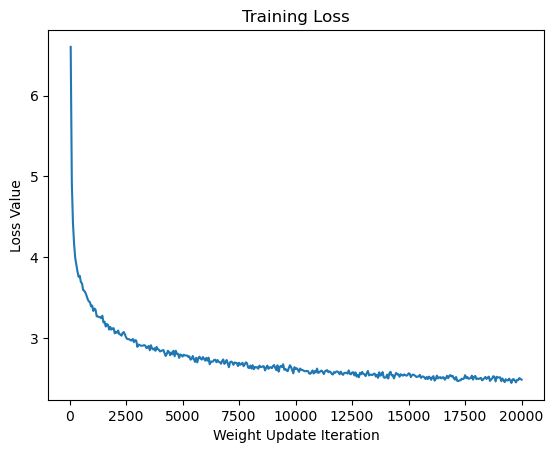

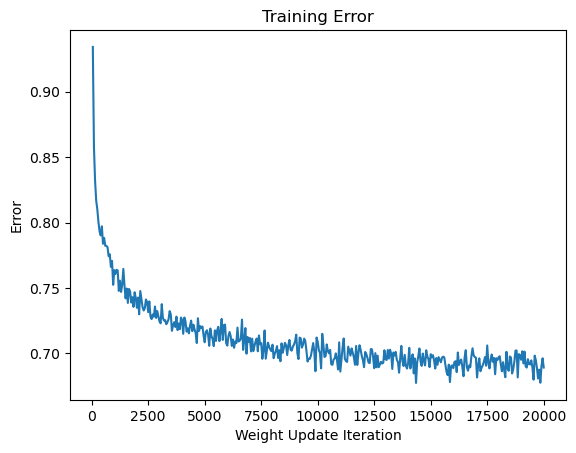

<Figure size 640x480 with 0 Axes>

In [ ]:
# output,_ = rnn(input[40].to(device))
# output = [unique_chars[i] for i in torch.argmax(output, dim=1).tolist()]
# output = torch.tensor(unique_chars)
# [torch.argmax(output, dim=1)]
# print(batches[40])
# # print((output))
# # print(output)
# print(error)
# print(current_labels)
# print(torch.argmax(output,dim=1))
# test = [1,2,3,4,5]

# training_error_values = [i.cpu().item() for i in training_error_values]
# validation_error_values = [i.cpu().item() for i in validation_error_values]
# validation_loss_values = [i.cpu().item() for i in validation_loss_values]


plt.figure()
plt.plot(x_vals,training_loss_values)
plt.xlabel('Weight Update Iteration')
plt.ylabel('Loss Value')
plt.title('Training Loss')
plt.figure()
plt.plot(x_vals, training_error_values)
plt.xlabel('Weight Update Iteration')
plt.ylabel('Error')
plt.title('Training Error')
plt.figure()
# plt.plot(validation_x_vals, validation_loss_values)
# plt.xlabel('Weight Update Iteration')
# plt.ylabel('Loss Value')
# plt.title('Validation Loss')
# plt.figure()
# plt.plot(validation_x_vals, validation_error_values)
# plt.xlabel('Weight Update Iteration')
# plt.ylabel('Error')
# plt.title('Validation Error')
# plt.show()

In [ ]:
test_temperature = 1.0
transformer_model.eval()
capital_letters = [chr(i) for i in range(65, 91)]
example_sentences = []
initialize = ["I went to the store."]
# initialize = ['Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is']
inference_tokens = 100
for i in range(1):
    sentence = initialize[i]
    tokenized_sentence = tokenizer.encode(sentence)
    next_char = torch.tensor(tokenized_sentence).long().unsqueeze(0).to(device)
    for j in range(inference_tokens):
        next_char = transformer_model(next_char)
        # print(next_char.shape)
        # print(next_char.shape)
        next_softmax = softmax_with_temperature(next_char, test_temperature)
        # predicted_char = torch.argmax(next_softmax,dim=1)
        predicted_char = torch.multinomial(next_softmax[0,-1],1)
        # letter = unique_chars[predicted_char[-1]]
        letter = tokenizer.decode([predicted_char.item()])
        sentence += letter
        # next_char = torch.tensor(tokenize(sentence)).long().to(device)
        next_tokenized_sentence = tokenizer.encode(sentence)
        next_char = torch.tensor(next_tokenized_sentence).unsqueeze(0).long().to(device)
    example_sentences.append(sentence)
example_sentences = np.array(example_sentences)
print(example_sentences[0])
# print(example_sentences[1])
# print(example_sentences[2])
# print(example_sentences[3])
# print(example_sentences[4])

I went to the store. I got it and you learned her lesson and promised to never forget the kind color she could. It was his favorite skills, and that someone, even if someone was not enough, his original self. And it made her very happy. The end. The end. The moral of this story is to never always listen to your friends. If you might ever make things don't stop you may always ask by eating something that you can be tempting. It's a great idea and angel."

 
